# Covid-19 Analysis - Part 4

- **Which businesses/types of businesses are the primary offenders for these COVID violations?**
- **What do you find when you look into the types of businesses that have been reported for COVID violations?**

## Preambule

More details of the problem

Dataset of hubNashville requests allows to see where violations occurred geographically, but it does not provide information in regard to the specific businesses that were reported.

- **Explore the businesses and types of businesses that have been reported**

*Warning: It will not be possible to match all violations to a business, and there will be ambiguities when trying to do this match, so do not spend all of your time on this task.*

To attempt to answer this, you have been provided data from the Google Places API. Each file is formatted as a json. The values are as follows:

1. `mapped_location`: The mapped location from the hubNashville dataset
1. `address`: The address from the hubNashville dataset
1. `results`: The first five results from a Google Maps API nearbysearch, ranked by proximity to the Mapped Location. See here for more details on the fields in the results.

- **Take these results and use them to match as many violations as possible to a business**
- **What do you find when you look into the types of businesses that have been reported for COVID violations?**

## Imports and Setups

A bunch of imports and setups

In [1]:
import glob
import json
import re
import requests

import datetime as dt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from io import StringIO
from ipywidgets import interact

Here are setups and defaults that we are using in this notebook

In [2]:
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', "{:,.10f}".format)
sns.set()

## Importing Data

Importing `hubNashville_cleaned.csv`

In [3]:
covid_19 = pd.read_csv("../data/hubNashville_cleaned.csv")

## Analysis Decisions

Some of the decisions we take as we run the analysis

- For date/time purposes, we will mainly adopt the `datetimme_opened`
- Dropping the records where the location coordinates were not specified: Since our analysis involves location, these would be useless
- Coordinates Precision: At least 4-decimal points

## Additional Cleanups

### Renaming the columns and dropping some columns

Some columns are renamed and some columns are dropped

- `Unnamed: 0`
- `index`

In [4]:
covid_19 = covid_19.drop(columns=["Unnamed: 0", "index"])
covid_19.columns = ["req_num", "status", "req_type", "subreq_type", "add_subreq_type", "datetime_opened", "datetime_closed", "req_origin", "state_issue", "closed_when_created", "address", "city", "council_district", "zip", "latitude", "longitude", "mapped_loc", "month_num", "day_num", "month_day", "month_name", "weekday"]
print(covid_19.shape)
covid_19.head()

(11632, 22)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri
1,479965,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-13 11:48:40,2020-10-13 13:48:08,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2112694295,-86.6943024067,"(36.211269429469425, -86.6943024067459)",10,13,10/13,Oct,Tue
2,392927,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-16 00:35:20,2020-06-17 14:28:19,hubNashville Community,False,False,2607 12th Ave S,NASHVILLE,18.0000000000,37204,36.1235000000,-86.7901300000,"(36.1235, -86.79013)",6,16,6/16,Jun,Tue
3,444512,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-13 18:50:31,2020-08-14 14:22:11,hubNashville Community,False,False,3200 Clarksville Pike,NASHVILLE,2.0000000000,37218,36.1941628000,-86.8313936000,"(36.1941628, -86.8313936)",8,13,8/13,Aug,Thu
4,444440,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-13 18:03:09,2020-08-14 14:18:59,hubNashville Community,False,False,20 Grundy St,NASHVILLE,19.0000000000,37203,36.1584397116,-86.7880380629,"(36.15843971160494, -86.7880380629013)",8,13,8/13,Aug,Thu


### Coordinates Precision: At least 5-decimal points

We should use at least 5-decimal point for making comparison for the perfect balance between *Accuracy* and *Flexibility* because of [GPS Precision](https://blis.com/precision-matters-critical-importance-decimal-places-five-lowest-go/)

Decimal Places | Decimal Degrees | Distance | Concept
:-------------:|:----------------|---------:|:-------
0 | 1.0 | 111 km | Can identify a Country or large Region from another
1 | 0.1 | 11.1 km | Can identify a large city from a neighbouring large city
2 | 0.01 | 1.11 km | Can identify a small village from the next
3 | 0.001 | 111 m | Can separate one neighbourhood or street from another
4 | 0.0001 | 11.1 m | Can identify an individual street or parcel of land.
5 | 0.00001 | 1.11 m | Capacity to distinguish one tree from another.
6 | 0.000001 | 11.1 cm | Measuring approximately 4 inches wide. Used for structural design & surveyance in engineering.
7 | 0.0000001 | 1.11 cm | Used for precision geographic surveying, representing the practical limit of the use of GPS.
8 | 0.00000001 | 1.11 mm | Conceptually the width of a paper clip. Can be used for charting volcanic movements & tectonic plate shifts.
9 | 0.000000001 | 111μm | Representative of the width of a strand of thread, now in the range of microscopy.

### Dropping records where the coordinates were not specified

Since our analysis involves location coordinates, these would be useless

In [5]:
covid_19 = covid_19[~covid_19["mapped_loc"].isna()]
print(covid_19.shape)

(11354, 22)


**Remarks**: Our dataset went from 11632 to 11354: 278 records did not have good location data

In [6]:
covid_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11354 entries, 0 to 11631
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   req_num              11354 non-null  int64  
 1   status               11354 non-null  object 
 2   req_type             11354 non-null  object 
 3   subreq_type          11354 non-null  object 
 4   add_subreq_type      11347 non-null  object 
 5   datetime_opened      11354 non-null  object 
 6   datetime_closed      11337 non-null  object 
 7   req_origin           11354 non-null  object 
 8   state_issue          11354 non-null  bool   
 9   closed_when_created  11354 non-null  bool   
 10  address              11256 non-null  object 
 11  city                 10652 non-null  object 
 12  council_district     10686 non-null  float64
 13  zip                  11354 non-null  int64  
 14  latitude             11354 non-null  float64
 15  longitude            11354 non-null 

### Adding the length of the coordinates decimal places

Adding `orig_lat_prec` and `orig_long_prec`

In [7]:
temp = covid_19["mapped_loc"].apply(lambda el: el.strip("(").strip(")").split(", ")).to_frame()
temp[['lat','long']] = pd.DataFrame(temp["mapped_loc"].tolist(), index=temp.index)
    
covid_19["orig_lat_prec"] = temp['lat'].apply(lambda x: len(x.split(".")[1]))
covid_19["orig_long_prec"] = temp['long'].apply(lambda x: len(x.split(".")[1]))

covid_19.head()

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,7,7
1,479965,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-13 11:48:40,2020-10-13 13:48:08,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2112694295,-86.6943024067,"(36.211269429469425, -86.6943024067459)",10,13,10/13,Oct,Tue,15,13
2,392927,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-16 00:35:20,2020-06-17 14:28:19,hubNashville Community,False,False,2607 12th Ave S,NASHVILLE,18.0000000000,37204,36.1235000000,-86.7901300000,"(36.1235, -86.79013)",6,16,6/16,Jun,Tue,4,5
3,444512,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-13 18:50:31,2020-08-14 14:22:11,hubNashville Community,False,False,3200 Clarksville Pike,NASHVILLE,2.0000000000,37218,36.1941628000,-86.8313936000,"(36.1941628, -86.8313936)",8,13,8/13,Aug,Thu,7,7
4,444440,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-13 18:03:09,2020-08-14 14:18:59,hubNashville Community,False,False,20 Grundy St,NASHVILLE,19.0000000000,37203,36.1584397116,-86.7880380629,"(36.15843971160494, -86.7880380629013)",8,13,8/13,Aug,Thu,14,13


In [8]:
print("Maximum Original Latitude Precision:", np.max(covid_19["orig_lat_prec"]))
print("Minimum Original Latitude Precision:", np.min(covid_19["orig_lat_prec"]))
print("Maximum Original Longitude Precision:", np.max(covid_19["orig_long_prec"]))
print("Minimum Original Longitude Precision:", np.min(covid_19["orig_long_prec"]))

Maximum Original Latitude Precision: 15
Minimum Original Latitude Precision: 1
Maximum Original Longitude Precision: 15
Minimum Original Longitude Precision: 2


#### How many records have precisions less than 5?

In [9]:
covid_19["orig_lat_prec"].value_counts().sort_index()

1        1
2        2
3      289
4      221
5     1937
6      609
7     3409
11       5
12      22
13     283
14    3497
15    1079
Name: orig_lat_prec, dtype: int64

In [10]:
covid_19["orig_long_prec"].value_counts().sort_index()

2        2
3      286
4      217
5     1962
6      651
7     3065
8      119
10       1
11      18
12      11
13     562
14    4457
15       3
Name: orig_long_prec, dtype: int64

### Distribution of Latitude and Longitude Precisions in `covid_19` Dataset

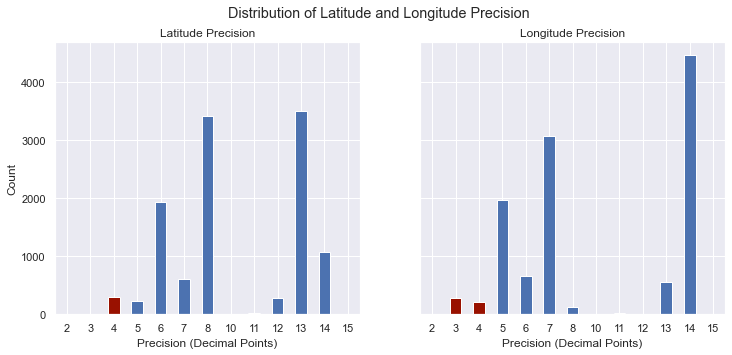

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12, 5))
colors = ['#991100' if num < 5 else 'C0' for num in range(2, 16)]

covid_19["orig_lat_prec"].value_counts().sort_index().plot(ax=ax[0], kind="bar", rot=0, color=colors)
covid_19["orig_long_prec"].value_counts().sort_index().plot(ax=ax[1], kind="bar", rot=0, color=colors)

fig.suptitle("Distribution of Latitude and Longitude Precision")

ax[0].set_title("Latitude Precision")
ax[0].set_xlabel("Precision (Decimal Points)")
ax[0].set_ylabel("Count");

ax[1].set_title("Longitude Precision")
ax[1].set_xlabel("Precision (Decimal Points)");

### Dropping Records with Precisions less than 5

We only want to focus on coordinates with 5-decimal places or more

In [12]:
covid_19 = covid_19[(covid_19["orig_lat_prec"] >= 5) & (covid_19["orig_long_prec"] >= 5)]
print(covid_19.shape)

(10625, 24)


In [13]:
11354 - 10625

729

**Remarks**: Our dataset went from 11354 to 10625: 729 records did not have good location data

## Importing Data

Importing `google_places_results`

Here, we are importing the data from each of the files and simply appending them into a list

In [14]:
list_of_files = glob.glob('../data/google_places_results/*.json')

In [15]:
gplaces = []

for path in list_of_files:
    with open(path, "r") as file:
        gplaces.extend(json.load(file))
        file.close()

display(len(gplaces))

4829

Here is the format of each element within this list of objects. Next, we will use this to parse the data point elements that we are interested in.

- `mapped_location`: "(lat, long)"
- `address`: string
- `results`: list of objects
  - `business_status`: string
  - `geometry`: object
    - `location`: object
      - `lat`: float
      - `lng`: float
    - `viewport`: string
      - `northeast`: object
        - `lat`: float
        - `lng`: float
      - `southwest`: object
        - `lat`: float
        - `lng`: float
  - `icon`: string
  - `name`: string
  - `opening_hours`: object
    - `open_now`: Bool
  - `place_id`: string
  - `plus_code`: object
    - `compound_code`: string
    - `global_code`: string
  - `rating`: float
  - `reference`: string
  - `scope`: string
  - `types`: list(string)
  - `user_ratings_total`: float
  - `vicinity`: string

In [16]:
def parse_gplace(gplace):
    """Function to parse, flatten, and cherry-pick the data points within the google place json. 
    If the data point does not exist, replace with None by using a defaultdict structure. 
    Returns a list of flatten results."""
    
    flat_results = []
    
    # Parsing through results
    for res in gplace["results"]:
        res = defaultdict(lambda : None, res) # If res does not exist, replace with None
        option = {
            "name": res["name"],
            "vicinity": res["vicinity"],
            "business_status": res["business_status"],
            "latitude": res["geometry"]["location"]["lat"] if res["geometry"] else None,
            "longitude": res["geometry"]["location"]["lng"] if res["geometry"] else None,
            "mapped_loc": gplace["mapped_location"],
            "mapped_address": gplace["address"],
            "icon": res["icon"],
            "compound_code": res["plus_code"]["compound_code"] if res["plus_code"] else None,
            "global_code": res["plus_code"]["global_code"] if res["plus_code"] else None,
            "rating": res["rating"],
            "user_ratings_total": res["user_ratings_total"],
            "types": res["types"],
            "place_id": res["place_id"]
        }
        flat_results.append(option)
    
    return flat_results

Now, we can go through all the element of `gplaces` and generate a list of this object to start building our dataframe

In [17]:
flattened_gplaces = []

for gplace in gplaces:
    flattened_gplaces.extend(parse_gplace(gplace))

len(flattened_gplaces)

24145

We can now use this flattened structure and convert it into a pandas dataframe

In [18]:
places = pd.DataFrame(flattened_gplaces)
print(places.shape)
places.head()

(24145, 14)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.0684753000,-86.6839672000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.6000000000,50.0000000000,"[beauty_salon, hair_care, point_of_interest, establishment]",ChIJlfxUC0FuZIgRa8G6Arf-BW8
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.0686579000,-86.6838130000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"3898+FF Nashville, TN, USA",868M3898+FF,4.0000000000,4.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJl59cc0FuZIgRkvAljwlcGg0
3,Hai Woon Dai,"2051 Antioch Pike, Antioch",OPERATIONAL,36.0684374000,-86.6839929000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.4000000000,558.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJKW-HCUFuZIgR9_z1PBY7088
4,"Dr. Babajide A. Bamigboye, MD","2031 Antioch Pike, Antioch",OPERATIONAL,36.0687196000,-86.6842314000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+F8 Nashville, TN, USA",868M3898+F8,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJNSKqCEFuZIgRG3Q1eih4goY


Checking some quick info about the dataset

In [19]:
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24145 entries, 0 to 24144
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                24145 non-null  object 
 1   vicinity            24145 non-null  object 
 2   business_status     24047 non-null  object 
 3   latitude            24145 non-null  float64
 4   longitude           24145 non-null  float64
 5   mapped_loc          24145 non-null  object 
 6   mapped_address      24145 non-null  object 
 7   icon                24145 non-null  object 
 8   compound_code       23908 non-null  object 
 9   global_code         23908 non-null  object 
 10  rating              15251 non-null  float64
 11  user_ratings_total  15251 non-null  float64
 12  types               24145 non-null  object 
 13  place_id            24145 non-null  object 
dtypes: float64(4), object(10)
memory usage: 2.6+ MB


### Adding the length of the coordinates decimal places

In [20]:
places["lat_prec"] = places['latitude'].apply(lambda x: len(str(x).split(".")[1]))
places["long_prec"] = places['longitude'].apply(lambda x: len(str(x).split(".")[1]))

places.head()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.0684753000,-86.6839672000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.6000000000,50.0000000000,"[beauty_salon, hair_care, point_of_interest, establishment]",ChIJlfxUC0FuZIgRa8G6Arf-BW8,7,7
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.0686579000,-86.6838130000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"3898+FF Nashville, TN, USA",868M3898+FF,4.0000000000,4.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJl59cc0FuZIgRkvAljwlcGg0,7,6
3,Hai Woon Dai,"2051 Antioch Pike, Antioch",OPERATIONAL,36.0684374000,-86.6839929000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.4000000000,558.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJKW-HCUFuZIgR9_z1PBY7088,7,14
4,"Dr. Babajide A. Bamigboye, MD","2031 Antioch Pike, Antioch",OPERATIONAL,36.0687196000,-86.6842314000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+F8 Nashville, TN, USA",868M3898+F8,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJNSKqCEFuZIgRG3Q1eih4goY,7,7


In [21]:
print("Maximum Latitude Precision:", np.max(places["lat_prec"]))
print("Minimum Latitude Precision:", np.min(places["lat_prec"]))
print("Maximum Longitude Precision:", np.max(places["long_prec"]))
print("Minimum Longitude Precision:", np.min(places["long_prec"]))

Maximum Latitude Precision: 14
Minimum Latitude Precision: 2
Maximum Longitude Precision: 14
Minimum Longitude Precision: 2


#### How many records have precisions less than 5?

In [22]:
places["lat_prec"].value_counts().sort_index()

2         4
3         4
4        78
5       430
6      4196
7     14528
14     4905
Name: lat_prec, dtype: int64

In [23]:
places["long_prec"].value_counts().sort_index()

2         3
3         6
4        86
5       416
6      3701
7     12827
14     7106
Name: long_prec, dtype: int64

## Coordinates Precisions in `google_places_results`

This is showing the distribution of Coordinates Precisions in Google Places

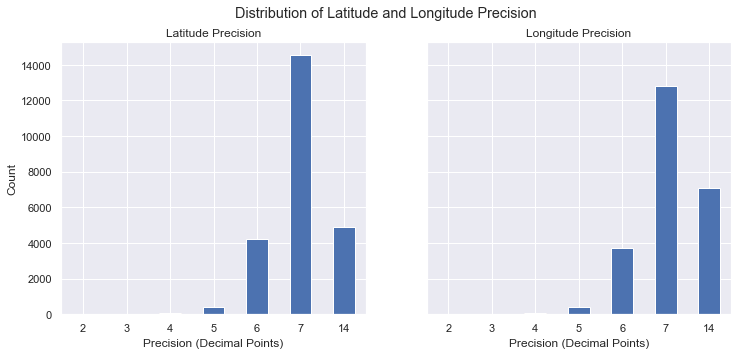

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12, 5))
colors = ['#991100' if num < 5 else 'C0' for num in range(2, 16)]

places["lat_prec"].value_counts().sort_index().plot(ax=ax[0], kind="bar", rot=0, color=colors)
places["long_prec"].value_counts().sort_index().plot(ax=ax[1], kind="bar", rot=0, color=colors)

fig.suptitle("Distribution of Latitude and Longitude Precision")

ax[0].set_title("Latitude Precision")
ax[0].set_xlabel("Precision (Decimal Points)")
ax[0].set_ylabel("Count");

ax[1].set_title("Longitude Precision")
ax[1].set_xlabel("Precision (Decimal Points)");

### Dropping Records with Precisions less than 5

We only want to focus on coordinates with 5-decimal places or more

In [25]:
places = places[(places["lat_prec"] >= 5) & (places["long_prec"] >= 5)]
print(places.shape)

(23986, 16)


**Remarks**: Our dataset went from 24145 to 23986: 159 records did not have good location data

## Primary Business Types in `google_places_results`

Adding the primary business type. This business type is extracted from the `icon` url.

In [26]:
places.head()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.0684753000,-86.6839672000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.6000000000,50.0000000000,"[beauty_salon, hair_care, point_of_interest, establishment]",ChIJlfxUC0FuZIgRa8G6Arf-BW8,7,7
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.0686579000,-86.6838130000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"3898+FF Nashville, TN, USA",868M3898+FF,4.0000000000,4.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJl59cc0FuZIgRkvAljwlcGg0,7,6
3,Hai Woon Dai,"2051 Antioch Pike, Antioch",OPERATIONAL,36.0684374000,-86.6839929000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.4000000000,558.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJKW-HCUFuZIgR9_z1PBY7088,7,14
4,"Dr. Babajide A. Bamigboye, MD","2031 Antioch Pike, Antioch",OPERATIONAL,36.0687196000,-86.6842314000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+F8 Nashville, TN, USA",868M3898+F8,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJNSKqCEFuZIgRG3Q1eih4goY,7,7


Here, we are extracting the primary business type from the `icon` string

In [27]:
places["primary_type"] = places["icon"].apply(lambda st: re.findall(r"\/(\w+)-", st)[0])\
                                       .apply(lambda st: re.sub(r"_", " ", st))\
                                       .apply(lambda st: st.title())
places.head()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.0684753000,-86.6839672000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.6000000000,50.0000000000,"[beauty_salon, hair_care, point_of_interest, establishment]",ChIJlfxUC0FuZIgRa8G6Arf-BW8,7,7,Generic Business
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.0686579000,-86.6838130000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"3898+FF Nashville, TN, USA",868M3898+FF,4.0000000000,4.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJl59cc0FuZIgRkvAljwlcGg0,7,6,Shopping
3,Hai Woon Dai,"2051 Antioch Pike, Antioch",OPERATIONAL,36.0684374000,-86.6839929000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.4000000000,558.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJKW-HCUFuZIgR9_z1PBY7088,7,14,Restaurant
4,"Dr. Babajide A. Bamigboye, MD","2031 Antioch Pike, Antioch",OPERATIONAL,36.0687196000,-86.6842314000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+F8 Nashville, TN, USA",868M3898+F8,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJNSKqCEFuZIgRG3Q1eih4goY,7,7,Generic Business


### What are all existing primary types?

In [28]:
places["primary_type"].value_counts()

Generic Business    13392
Shopping             3726
Restaurant           2413
School                799
Atm                   483
Worship General       453
Gas Station           403
Civic Building        383
Lodging               314
Bar                   297
Park                  219
Cafe                  200
Parking               181
Pharmacy              165
Bank                  150
Bus                   134
Cemetery Grave         66
Hospital               58
Museum                 32
Police                 25
Golf                   24
Post Office            22
Movies                 15
Library                 8
Geocode                 5
Stadium                 4
Worship Islam           3
Camping                 3
Worship Dharma          3
Worship Jewish          2
Airport                 2
Worship Hindu           2
Name: primary_type, dtype: int64

Let's generalize some of these:
- `worship_islam` -> `worship_general`
- `worship_dharma` -> `worship_general`
- `worship_jewish` -> `worship_general`
- `worship_hindu` -> `worship_general`

In [29]:
places.loc[(places["primary_type"] == "Worship Islam"), "primary_type"] = "Worship General"
places.loc[(places["primary_type"] == "Worship Dharma"), "primary_type"] = "Worship General"
places.loc[(places["primary_type"] == "Worship Jewish"), "primary_type"] = "Worship General"
places.loc[(places["primary_type"] == "Worship Hindu"), "primary_type"] = "Worship General"

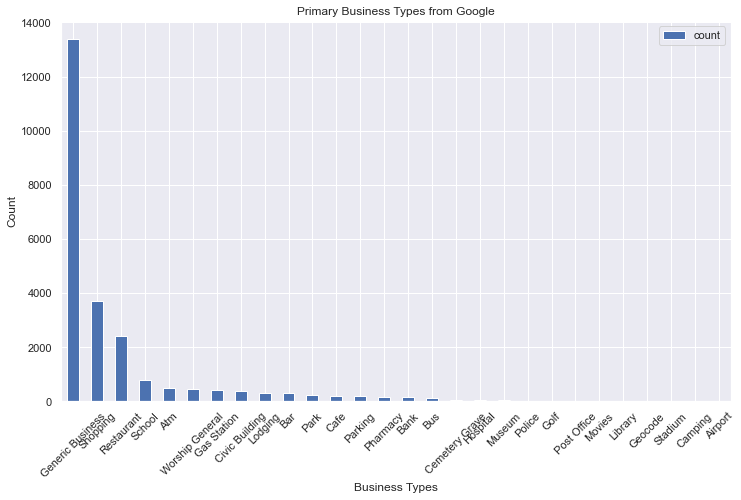

In [30]:
businesses = places["primary_type"].value_counts().to_frame().reset_index()
businesses.columns = ["primary_type", "count"]
businesses.plot(x="primary_type", y="count", kind='bar', figsize=(12,7), rot=45)
plt.title("Primary Business Types from Google")
plt.xlabel("Business Types")
plt.ylabel("Count");

## Which are the top 10 Business Types?

It appears that the top 10 business types in this dataset are as follow

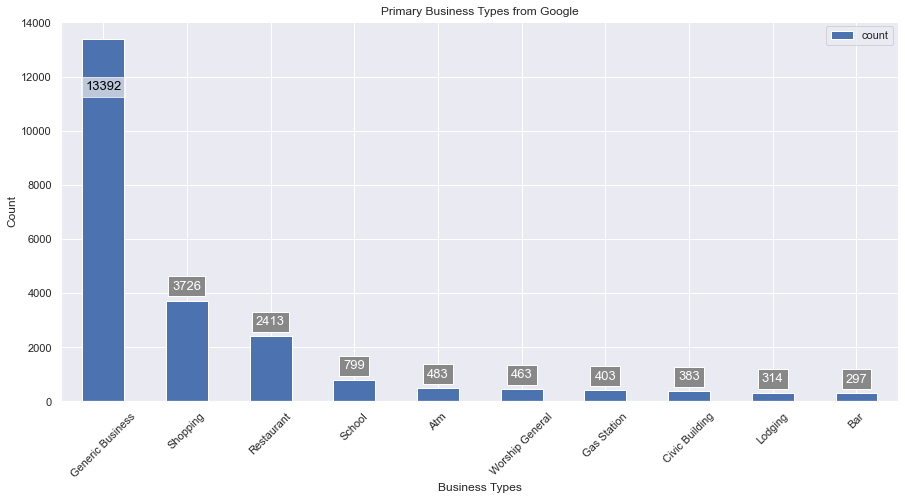

In [31]:
ax = businesses.nlargest(10, "count").plot(x="primary_type", y="count", kind='bar', figsize=(15,7), rot=45)

# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels = [x for x in businesses["count"]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 5000):
        ax.text(rect.get_x() + rect.get_width() / 2, height-2000, label, ha='center', va='bottom', color="black", fontsize=13).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+300, label, ha='center', va='bottom', color="white", fontsize=13).set_bbox(dict(facecolor='#888'))

plt.title("Primary Business Types from Google")
plt.xlabel("Business Types")
plt.ylabel("Count");

## All Types of Business

Here, we are going to get all the unique business types from the `types` column

In [32]:
unique_types = set()

for sublist in list(places["types"]):
    for tp in sublist:
        unique_types.add(tp)

print(len(unique_types))

101


### Appending the business types to the data frame and populating accordingly

Creating a new column for each of the unique types and setting True or False if the business type match

In [33]:
# for tp in unique_types:    
#     places[tp] = places["types"].apply(lambda types: tp in types)

# places.head()

## Are all these businesses operational?

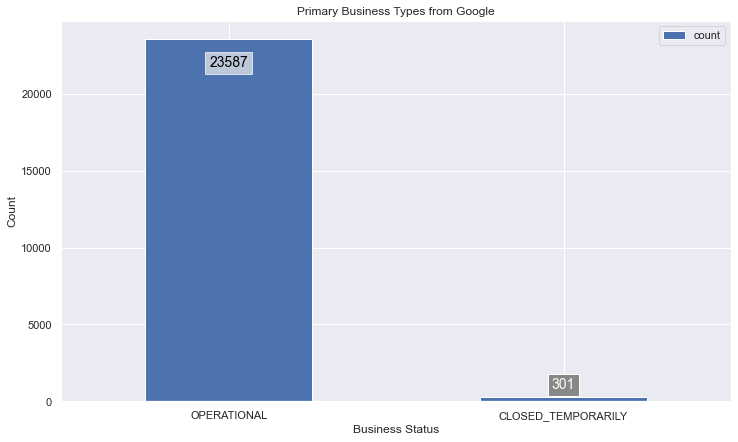

In [34]:
business_statuses = places["business_status"].value_counts().to_frame().reset_index()
business_statuses.columns = ["business_status", "count"]
ax = business_statuses.plot(kind="bar", x="business_status", y="count", rot=0, figsize=(12,7))
# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels = [x for x in business_statuses["count"]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 5000):
        ax.text(rect.get_x() + rect.get_width() / 2, height-2000, label, ha='center', va='bottom', color="black", fontsize=14).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+300, label, ha='center', va='bottom', color="white", fontsize=14).set_bbox(dict(facecolor='#888'))

plt.title("Primary Business Types from Google")
plt.xlabel("Business Status")
plt.ylabel("Count");

## Splitting `mapped_loc`

Here, we are splitting `mapped_loc` into `mapped_loc_lat` and `mpped_loc_long` and assign them to the dataframe

In [35]:
places["mapped_loc_lat"] = places["mapped_loc"].apply(lambda loc: np.double(loc.strip("(").strip(")").split(", ")[0]))
places["mapped_loc_long"] = places["mapped_loc"].apply(lambda loc: np.double(loc.strip("(").strip(")").split(", ")[1]))
places.head()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685457000,-86.6838975000
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.0684753000,-86.6839672000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.6000000000,50.0000000000,"[beauty_salon, hair_care, point_of_interest, establishment]",ChIJlfxUC0FuZIgRa8G6Arf-BW8,7,7,Generic Business,36.0685457000,-86.6838975000
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.0686579000,-86.6838130000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"3898+FF Nashville, TN, USA",868M3898+FF,4.0000000000,4.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJl59cc0FuZIgRkvAljwlcGg0,7,6,Shopping,36.0685457000,-86.6838975000
3,Hai Woon Dai,"2051 Antioch Pike, Antioch",OPERATIONAL,36.0684374000,-86.6839929000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"3898+9C Nashville, TN, USA",868M3898+9C,4.4000000000,558.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJKW-HCUFuZIgR9_z1PBY7088,7,14,Restaurant,36.0685457000,-86.6838975000
4,"Dr. Babajide A. Bamigboye, MD","2031 Antioch Pike, Antioch",OPERATIONAL,36.0687196000,-86.6842314000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"3898+F8 Nashville, TN, USA",868M3898+F8,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJNSKqCEFuZIgRG3Q1eih4goY,7,7,Generic Business,36.0685457000,-86.6838975000


### Exact Match Places

These are the exact match places where the `latitude` and `longitude` match exactly the `mapped_loc_lat` and the `mapped_loc_long`

In [36]:
places_exact_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_exact_match.shape)
places_exact_match.head()

(1437, 19)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685457000,-86.6838975000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685457000,-86.6838975000
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.2328375000,-86.7583026000,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5000000000,905.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,7,14,Restaurant,36.2328375000,-86.7583026000
40,Tennessee Glass Co,"651 Thompson Lane, Nashville",OPERATIONAL,36.1105402000,-86.7564862000,"(36.1105402, -86.7564862)","651 Thompson Ln, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"466V+6C Nashville, TN, USA",868M466V+6C,3.9000000000,24.0000000000,"[furniture_store, home_goods_store, general_contractor, point_of_interest, store, establishment]",ChIJ1fbUV-tlZIgRcbH3KaCrfr0,7,7,Generic Business,36.1105402000,-86.7564862000
55,Brooks Household Staffing,"3820 Charlotte Avenue, Nashville",OPERATIONAL,36.1529540000,-86.8320627000,"(36.152954, -86.83206270000001)","3820 Charlotte Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5539+55 Nashville, TN, USA",868M5539+55,nan,nan,"[point_of_interest, establishment]",ChIJvVD1zwZhZIgRcGk9mjVDKQ4,6,14,Generic Business,36.1529540000,-86.8320627000
56,Happily Grey,"3820 Charlotte Avenue Ste. 147, Nashville",OPERATIONAL,36.1529540000,-86.8320627000,"(36.152954, -86.83206270000001)","3820 Charlotte Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"5539+55 Nashville, TN, USA",868M5539+55,5.0000000000,1.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJhW0CDVthZIgR8qOQ2SxD4VY,6,14,Shopping,36.1529540000,-86.8320627000


What do we get if we join/merge this with covid-data?

In [37]:
covid_19_exact_places = covid_19.merge(places_exact_match, on=["latitude", "longitude", "mapped_loc"], suffixes=("_cov", "_plc"))
print(covid_19_exact_places.shape)
covid_19_exact_places.head()

(1659, 40)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,470583,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-25 07:11:18,2020-09-25 14:13:46,hubNashville Community,False,False,1500 Church St,NASHVILLE,19.0000000000,37203,36.1574825000,-86.7930523000,"(36.1574825, -86.7930523)",9,25,9/25,Sep,Fri,7,7,Sharp Stephan C MD,"1500 Church Street, Nashville",OPERATIONAL,"1500 Church St, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5644+XQ Nashville, TN, USA",868M5644+XQ,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJUy9oc-1mZIgRlG9FC734pjI,7,7,Generic Business,36.1574825000,-86.7930523000
1,470583,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-25 07:11:18,2020-09-25 14:13:46,hubNashville Community,False,False,1500 Church St,NASHVILLE,19.0000000000,37203,36.1574825000,-86.7930523000,"(36.1574825, -86.7930523)",9,25,9/25,Sep,Fri,7,7,Clinical Research Associates Inc,"1500 Church Street # 100, Nashville",OPERATIONAL,"1500 Church St, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5644+XQ Nashville, TN, USA",868M5644+XQ,3.5000000000,4.0000000000,"[doctor, health, point_of_interest, establishment]",ChIJUy9oc-1mZIgR7xKuFnBR_no,7,7,Generic Business,36.1574825000,-86.7930523000
2,428746,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-28 02:19:03,2020-07-28 18:37:38,hubNashville Community,False,False,3410 Gallatin Pike,NASHVILLE,7.0000000000,37216,36.2101188000,-86.7324397000,"(36.2101188, -86.7324397)",7,28,7/28,Jul,Tue,7,7,Kroger,"3410 Gallatin Pike, Nashville",OPERATIONAL,"3410 Gallatin Pike, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6769+22 Nashville, TN, USA",868M6769+22,3.9000000000,890.0000000000,"[grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJZyYDJgVoZIgRp_UaluUQWjY,7,7,Shopping,36.2101188000,-86.7324397000
3,428746,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-28 02:19:03,2020-07-28 18:37:38,hubNashville Community,False,False,3410 Gallatin Pike,NASHVILLE,7.0000000000,37216,36.2101188000,-86.7324397000,"(36.2101188, -86.7324397)",7,28,7/28,Jul,Tue,7,7,Kroger,"3410 Gallatin Pike, Nashville",OPERATIONAL,"3410 Gallatin Pike, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6769+22 Nashville, TN, USA",868M6769+22,3.9000000000,890.0000000000,"[grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJZyYDJgVoZIgRp_UaluUQWjY,7,7,Shopping,36.2101188000,-86.7324397000
4,370030,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-17 15:02:52,2020-05-18 16:27:08,hubNashville Community,False,False,3410 Gallatin Pike,NaN,nan,0,36.2101188000,-86.7324397000,"(36.2101188, -86.7324397)",5,17,5/17,May,Sun,7,7,Kroger,"3410 Gallatin Pike, Nashville",OPERATIONAL,"3410 Gallatin Pike, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6769+22 Nashville, TN, USA",868M6769+22,3.9000000000,890.0000000000,"[grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJZyYDJgVoZIgRp_UaluUQWjY,7,7,Shopping,36.2101188000,-86.7324397000


### Matched Places With 6 Decimals Points of Coordinate

In [38]:
# df.select_dtypes(include=['float64'])

In [39]:
covid_19[["latitude", "longitude"]] = covid_19[["latitude", "longitude"]].round(6)
covid_19[["latitude", "longitude"]].head()

,latitude,longitude
0,36.0685460000,-86.6838980000
1,36.2112690000,-86.6943020000
3,36.1941630000,-86.8313940000
4,36.1584400000,-86.7880380000
5,36.1750090000,-86.7585450000


In [40]:
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]] = places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].round(6)
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].head()

,latitude,longitude,mapped_loc_lat,mapped_loc_long
0,36.0685460000,-86.6838980000,36.0685460000,-86.6838980000
1,36.0684750000,-86.6839670000,36.0685460000,-86.6838980000
2,36.0686580000,-86.6838130000,36.0685460000,-86.6838980000
3,36.0684370000,-86.6839930000,36.0685460000,-86.6838980000
4,36.0687200000,-86.6842310000,36.0685460000,-86.6838980000


Let's apply the same steps as previously

In [41]:
places_6dec_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_6dec_match.shape)
places_6dec_match.head()

(1628, 19)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685460000,-86.6838980000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685460000,-86.6838980000
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.2328380000,-86.7583030000,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5000000000,905.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,7,14,Restaurant,36.2328380000,-86.7583030000
40,Tennessee Glass Co,"651 Thompson Lane, Nashville",OPERATIONAL,36.1105400000,-86.7564860000,"(36.1105402, -86.7564862)","651 Thompson Ln, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"466V+6C Nashville, TN, USA",868M466V+6C,3.9000000000,24.0000000000,"[furniture_store, home_goods_store, general_contractor, point_of_interest, store, establishment]",ChIJ1fbUV-tlZIgRcbH3KaCrfr0,7,7,Generic Business,36.1105400000,-86.7564860000
55,Brooks Household Staffing,"3820 Charlotte Avenue, Nashville",OPERATIONAL,36.1529540000,-86.8320630000,"(36.152954, -86.83206270000001)","3820 Charlotte Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5539+55 Nashville, TN, USA",868M5539+55,nan,nan,"[point_of_interest, establishment]",ChIJvVD1zwZhZIgRcGk9mjVDKQ4,6,14,Generic Business,36.1529540000,-86.8320630000
56,Happily Grey,"3820 Charlotte Avenue Ste. 147, Nashville",OPERATIONAL,36.1529540000,-86.8320630000,"(36.152954, -86.83206270000001)","3820 Charlotte Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"5539+55 Nashville, TN, USA",868M5539+55,5.0000000000,1.0000000000,"[clothing_store, point_of_interest, store, establishment]",ChIJhW0CDVthZIgR8qOQ2SxD4VY,6,14,Shopping,36.1529540000,-86.8320630000


What do we get if we merge this with the covid data?

In [42]:
covid_19_6dec_places = covid_19.merge(places_6dec_match, on=["latitude", "longitude"], suffixes=("_cov", "_plc"))
print(covid_19_6dec_places.shape)
covid_19_6dec_places.head()

(3851, 41)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685460000,-86.6838980000,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685460000,-86.6838980000
1,368950,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-15 15:22:39,2020-05-18 16:56:15,Phone,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685460000,-86.6838980000,"(36.0685457, -86.6838975)",5,15,5/15,May,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685460000,-86.6838980000
2,435283,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-02 01:44:36,2020-08-03 17:25:43,Mobile App,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685460000,-86.6838980000,"(36.0685457, -86.6838975)",8,2,8/2,Aug,Sun,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685460000,-86.6838980000
3,407552,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-04 13:35:24,2020-07-06 17:59:11,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685460000,-86.6838980000,"(36.0685457, -86.6838975)",7,4,7/4,Jul,Sat,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685460000,-86.6838980000
4,387699,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-09 18:00:40,2020-06-10 18:26:24,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685460000,-86.6838980000,"(36.0685457, -86.6838975)",6,9,6/9,Jun,Tue,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685460000,-86.6838980000


### Matched Places With 5 Decimal Points of Coordinate

In [43]:
covid_19[["latitude", "longitude"]] = covid_19[["latitude", "longitude"]].round(5)
covid_19[["latitude", "longitude"]].head()

,latitude,longitude
0,36.0685500000,-86.6839000000
1,36.2112700000,-86.6943000000
3,36.1941600000,-86.8313900000
4,36.1584400000,-86.7880400000
5,36.1750100000,-86.7585400000


In [44]:
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]] = places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].round(5)
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].head()

,latitude,longitude,mapped_loc_lat,mapped_loc_long
0,36.0685500000,-86.6839000000,36.0685500000,-86.6839000000
1,36.0684800000,-86.6839700000,36.0685500000,-86.6839000000
2,36.0686600000,-86.6838100000,36.0685500000,-86.6839000000
3,36.0684400000,-86.6839900000,36.0685500000,-86.6839000000
4,36.0687200000,-86.6842300000,36.0685500000,-86.6839000000


Let's apply the same steps as previously

In [45]:
places_5dec_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_5dec_match.shape)
places_5dec_match.head()

(2402, 19)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
30,Frankie Pierce Park,"130 LifeWay Plaza, Nashville",OPERATIONAL,36.1650200000,-86.7896800000,"(36.16502, -86.78968)","130 LifeWay Plaza, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/park-71.png,"5686+24 Nashville, TN, USA",868M5686+24,4.7000000000,15.0000000000,"[park, point_of_interest, establishment]",ChIJo5bPxhhnZIgRH2fr15uroaM,6,14,Park,36.1650200000,-86.7896800000
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.2328400000,-86.7583000000,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5000000000,905.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,7,14,Restaurant,36.2328400000,-86.7583000000
40,Tennessee Glass Co,"651 Thompson Lane, Nashville",OPERATIONAL,36.1105400000,-86.7564900000,"(36.1105402, -86.7564862)","651 Thompson Ln, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"466V+6C Nashville, TN, USA",868M466V+6C,3.9000000000,24.0000000000,"[furniture_store, home_goods_store, general_contractor, point_of_interest, store, establishment]",ChIJ1fbUV-tlZIgRcbH3KaCrfr0,7,7,Generic Business,36.1105400000,-86.7564900000
55,Brooks Household Staffing,"3820 Charlotte Avenue, Nashville",OPERATIONAL,36.1529500000,-86.8320600000,"(36.152954, -86.83206270000001)","3820 Charlotte Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5539+55 Nashville, TN, USA",868M5539+55,nan,nan,"[point_of_interest, establishment]",ChIJvVD1zwZhZIgRcGk9mjVDKQ4,6,14,Generic Business,36.1529500000,-86.8320600000


What do we get if we merge this with the covid data?

In [46]:
covid_19_5dec_places = covid_19.merge(places_5dec_match, on=["latitude", "longitude"], suffixes=("_cov", "_plc"))
print(covid_19_5dec_places.shape)
covid_19_5dec_places.head()

(5574, 41)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
1,368950,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-15 15:22:39,2020-05-18 16:56:15,Phone,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",5,15,5/15,May,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
2,435283,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-02 01:44:36,2020-08-03 17:25:43,Mobile App,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",8,2,8/2,Aug,Sun,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
3,407552,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-04 13:35:24,2020-07-06 17:59:11,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",7,4,7/4,Jul,Sat,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
4,387699,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-09 18:00:40,2020-06-10 18:26:24,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",6,9,6/9,Jun,Tue,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000


### Matched Places With 4 Decimal Points of Coordinate

In [47]:
covid_19[["latitude", "longitude"]] = covid_19[["latitude", "longitude"]].round(4)
covid_19[["latitude", "longitude"]].head()

,latitude,longitude
0,36.0686000000,-86.6839000000
1,36.2113000000,-86.6943000000
3,36.1942000000,-86.8314000000
4,36.1584000000,-86.7880000000
5,36.1750000000,-86.7585000000


In [48]:
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]] = places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].round(4)
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].head()

,latitude,longitude,mapped_loc_lat,mapped_loc_long
0,36.0686000000,-86.6839000000,36.0686000000,-86.6839000000
1,36.0685000000,-86.6840000000,36.0686000000,-86.6839000000
2,36.0687000000,-86.6838000000,36.0686000000,-86.6839000000
3,36.0684000000,-86.6840000000,36.0686000000,-86.6839000000
4,36.0687000000,-86.6842000000,36.0686000000,-86.6839000000


Let's apply the same steps as previously

In [49]:
places_4dec_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_4dec_match.shape)
places_4dec_match.head()

(3950, 19)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0686000000,-86.6839000000,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0686000000,-86.6839000000
20,Baldwin Showcase,"Grundy Street, Nashville",OPERATIONAL,36.1584000000,-86.7880000000,"(36.15843971160494, -86.7880380629013)","20 Grundy St, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5656+8R Nashville, TN, USA",868M5656+8R,nan,nan,"[point_of_interest, establishment]",ChIJAwo2mPNmZIgREqZDFVT-Trw,14,7,Generic Business,36.1584000000,-86.7880000000
30,Frankie Pierce Park,"130 LifeWay Plaza, Nashville",OPERATIONAL,36.1650000000,-86.7897000000,"(36.16502, -86.78968)","130 LifeWay Plaza, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/park-71.png,"5686+24 Nashville, TN, USA",868M5686+24,4.7000000000,15.0000000000,"[park, point_of_interest, establishment]",ChIJo5bPxhhnZIgRH2fr15uroaM,6,14,Park,36.1650000000,-86.7897000000
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.2328000000,-86.7583000000,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5000000000,905.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,7,14,Restaurant,36.2328000000,-86.7583000000
40,Tennessee Glass Co,"651 Thompson Lane, Nashville",OPERATIONAL,36.1105000000,-86.7565000000,"(36.1105402, -86.7564862)","651 Thompson Ln, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"466V+6C Nashville, TN, USA",868M466V+6C,3.9000000000,24.0000000000,"[furniture_store, home_goods_store, general_contractor, point_of_interest, store, establishment]",ChIJ1fbUV-tlZIgRcbH3KaCrfr0,7,7,Generic Business,36.1105000000,-86.7565000000


What do we get if we merge this with the covid data?

In [50]:
covid_19_4dec_places = covid_19.merge(places_4dec_match, on=["latitude", "longitude"], suffixes=("_cov", "_plc"))
print(covid_19_4dec_places.shape)
covid_19_4dec_places.head()

(9857, 41)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0686000000,-86.6839000000,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0686000000,-86.6839000000
1,357152,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-01 23:29:23,2020-05-05 15:16:55,hubNashville Community,False,False,2037 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0686000000,-86.6839000000,"(36.06863711156684, -86.68388089580999)",5,1,5/1,May,Fri,14,14,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0686000000,-86.6839000000
2,375518,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-24 02:12:40,2020-05-26 14:45:44,hubNashville Community,False,False,2037 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0686000000,-86.6839000000,"(36.06863711156684, -86.68388140674593)",5,24,5/24,May,Sun,14,14,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0686000000,-86.6839000000
3,356409,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-01 03:09:40,2020-05-01 14:54:52,hubNashville Community,False,False,2037 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0686000000,-86.6839000000,"(36.06863711156684, -86.68388089580999)",5,1,5/1,May,Fri,14,14,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0686000000,-86.6839000000
4,379263,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-29 11:44:47,2020-05-29 15:53:30,hubNashville Community,False,False,2037 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0686000000,-86.6839000000,"(36.06863711156684, -86.68388140674593)",5,29,5/29,May,Fri,14,14,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0686000000,-86.6839000000


In [51]:
# covid_19_4dec_places[(covid_19_4dec_places["latitude"] == 36.0686) & (covid_19_4dec_places["longitude"] == -86.6839)]
covid_19_4dec_places.tail()

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
9852,486406,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-22 16:48:24,2020-10-23 13:45:05,hubNashville Community,False,False,3918 Lebanon Pike,HERMITAGE,14.0000000000,37076,36.1946000000,-86.6234000000,"(36.1946271, -86.6234053)",10,22,10/22,Oct,Thu,7,7,Super Wok,"3918 Lebanon Pike, Hermitage",OPERATIONAL,"(36.1946271, -86.6234053)","3918 Lebanon Pike, Hermitage",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"59VG+VJ Nashville, TN, USA",868M59VG+VJ,3.6000000000,135.0000000000,"[meal_delivery, restaurant, food, point_of_interest, establishment]",ChIJlXSyeWBqZIgRDLQmUZOdMsQ,7,7,Restaurant,36.1946000000,-86.6234000000
9853,486328,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-22 16:02:50,2020-10-23 13:44:32,Phone,False,False,420 Harding Pl,NASHVILLE,26.0000000000,37211,36.0793000000,-86.7275000000,"(36.07927, -86.72747)",10,22,10/22,Oct,Thu,5,5,Patel Brothers,"420 Harding Place, Nashville",OPERATIONAL,"(36.07927, -86.72747)","420 Harding Pl, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"37HF+P2 Nashville, TN, USA",868M37HF+P2,4.2000000000,"1,304.0000000000","[supermarket, grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJsWiI55tvZIgRC4laQo4OJ2k,14,7,Shopping,36.0793000000,-86.7275000000
9854,485192,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-21 14:20:57,2020-10-22 13:44:06,hubNashville Community,False,False,1722 West End Ave,NASHVILLE,21.0000000000,37203,36.1533000000,-86.7960000000,"(36.153299711602756, -86.7960281)",10,21,10/21,Oct,Wed,15,7,Golden Coast,"1722 West End Avenue, Nashville",OPERATIONAL,"(36.153299711602756, -86.7960281)","1722 West End Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"5633+8H Nashville, TN, USA",868M5633+8H,3.4000000000,19.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJzZOJNEJnZIgRHePPaUD_5bM,6,6,Restaurant,36.1533000000,-86.7960000000
9855,485192,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-21 14:20:57,2020-10-22 13:44:06,hubNashville Community,False,False,1722 West End Ave,NASHVILLE,21.0000000000,37203,36.1533000000,-86.7960000000,"(36.153299711602756, -86.7960281)",10,21,10/21,Oct,Wed,15,7,Shabu-Shabu,"1722 West End Avenue, Nashville",OPERATIONAL,"(36.153299711602756, -86.7960281)","1722 West End Ave, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"5633+8H Nashville, TN, USA",868M5633+8H,4.6000000000,10.0000000000,"[restaurant, food, point_of_interest, establishment]",ChIJ9bzTrAhnZIgRPIE2bC9xIb4,6,6,Restaurant,36.1533000000,-86.7960000000
9856,486129,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-22 13:47:46,2020-10-23 13:39:00,Phone,False,False,5900 Charlotte Pike,NASHVILLE,20.0000000000,37209,36.1496000000,-86.8634000000,"(36.14962999999999, -86.8633976)",10,22,10/22,Oct,Thu,14,7,Richland Head Start,"5900 Charlotte Pike, Nashville",OPERATIONAL,"(36.14963, -86.8634)","5900 Charlotte Pike, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/school-71.png,"44XP+RJ Nashville, TN, USA",868M44XP+RJ,2.0000000000,6.0000000000,"[school, point_of_interest, establishment]",ChIJXzRnmJ1hZIgRGUl0_CTTyAE,7,7,School,36.1496000000,-86.8634000000


### Checking the Numbers

What do our number increase looks like with each cases?

In [52]:
data_numbers = pd.DataFrame([{
    "case": "Using Exact Match",
    "places_coord_match": places_exact_match.shape[0],
    "covid_19_match": covid_19_exact_places.shape[0]
}, {
    "case": "Using 6-Decimal Coordinates",
    "places_coord_match": places_6dec_match.shape[0],
    "covid_19_match": covid_19_6dec_places.shape[0]
}, {
    "case": "Using 5-Decimal Coordinates",
    "places_coord_match": places_5dec_match.shape[0],
    "covid_19_match": covid_19_5dec_places.shape[0]
}, {
    "case": "Using 4-Decimal Coordinates",
    "places_coord_match": places_4dec_match.shape[0],
    "covid_19_match": covid_19_4dec_places.shape[0]
}, {
    "case": "Original Datasets",
    "places_coord_match": places.shape[0],
    "covid_19_match": covid_19.shape[0]
}])
data_numbers

,case,places_coord_match,covid_19_match
0,Using Exact Match,1437,1659
1,Using 6-Decimal Coordinates,1628,3851
2,Using 5-Decimal Coordinates,2402,5574
3,Using 4-Decimal Coordinates,3950,9857
4,Original Datasets,23986,10625


## Comparing Different Methods of Match

<ipython-input-53-033170a13517>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "5k", "10k", "15k", "20k", "25k"], fontsize=13);


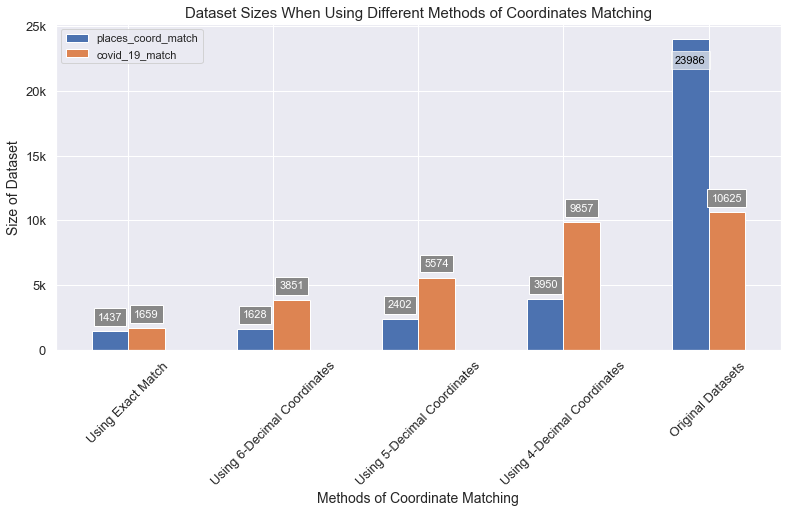

In [53]:
ax = data_numbers.plot(x="case", kind="bar", by="rows", rot=45, figsize=(13,6))

# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels_1 = [x for x in data_numbers["places_coord_match"]]
labels_2 = [x for x in data_numbers["covid_19_match"]]
labels = labels_1 + labels_2

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 20000):
        ax.text(rect.get_x() + rect.get_width() / 2, height-2000, label, ha='center', va='bottom', color="black", fontsize=11).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+700, label, ha='center', va='bottom', color="white", fontsize=11).set_bbox(dict(facecolor='#888'))

plt.title("Dataset Sizes When Using Different Methods of Coordinates Matching", fontsize=15)
ax.set_xlabel("Methods of Coordinate Matching", fontsize=14)
ax.set_ylabel("Size of Dataset", fontsize=14)
ax.tick_params(axis="x", labelsize=13)
ax.set_yticklabels(["0", "5k", "10k", "15k", "20k", "25k"], fontsize=13);

## What if we match on the address instead?

Nope. Dead end. Forget it for now.

First, we need to normalize the address

In [54]:
covid_19[covid_19['address'] == '2800 Opryland Dr']

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec
1,479965,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-13 11:48:40,2020-10-13 13:48:08,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2113000000,-86.6943000000,"(36.211269429469425, -86.6943024067459)",10,13,10/13,Oct,Tue,15,13
3019,412343,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-09 19:27:04,2020-07-10 15:42:03,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2125000000,-86.6961000000,"(36.212508761627944, -86.69605759325408)",7,9,7/9,Jul,Thu,15,14
7527,411539,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-09 02:23:16,2020-07-09 17:56:28,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2125000000,-86.6961000000,"(36.212508761627944, -86.69605759325408)",7,9,7/9,Jul,Thu,15,14
7579,410502,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-08 07:59:52,2020-07-08 19:37:48,hubNashville Community,False,False,2800 Opryland Dr,NaN,nan,0,36.2126000000,-86.6960000000,"(36.2125561, -86.69604149999999)",7,8,7/8,Jul,Wed,7,14
7639,412327,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-09 19:18:40,2020-07-10 17:35:40,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2125000000,-86.6961000000,"(36.212508761627944, -86.69605759325408)",7,9,7/9,Jul,Thu,15,14
7846,415618,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-14 13:39:18,2020-07-15 17:22:37,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2113000000,-86.6943000000,"(36.211269429469425, -86.6943024067459)",7,14,7/14,Jul,Tue,15,13
8403,421868,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-21 13:56:36,2020-07-22 18:37:32,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2113000000,-86.6943000000,"(36.21126942946945, -86.6943024067459)",7,21,7/21,Jul,Tue,14,13
8965,441779,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-10 18:42:35,2020-08-11 15:19:44,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2126000000,-86.6940000000,"(36.21265036162803, -86.6940195067459)",8,10,8/10,Aug,Mon,14,13
9126,445931,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-16 13:37:13,2020-08-17 18:17:25,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2113000000,-86.6943000000,"(36.211269429469425, -86.69430189580997)",8,16,8/16,Aug,Sun,15,14
9895,458901,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-05 00:04:39,2020-09-08 14:09:19,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0000000000,37214,36.2126000000,-86.6938000000,"(36.21265036162803, -86.69378874999998)",9,5,9/5,Sep,Sat,14,14


In [55]:
places[places['vicinity'].str.contains('2800 Opryland')]

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
5,Best Buy Express Kiosk,"2800 Opryland Dr, Nashville",OPERATIONAL,36.2114000000,-86.6941000000,"(36.211269429469425, -86.6943024067459)","2800 Opryland Dr, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"6864+H8 Nashville, TN, USA",868M6864+H8,5.0000000000,4.0000000000,"[point_of_interest, establishment]",ChIJ3eiSt9BpZIgRbrElosHvXLU,7,6,Generic Business,36.2113000000,-86.6943000000
7,Imaging USA 2018,"Gaylord Opryland Resort & Convention Center, 2800 Opryland Drive, Nashville",OPERATIONAL,36.2114000000,-86.6945000000,"(36.211269429469425, -86.6943024067459)","2800 Opryland Dr, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/lodging-71.png,"6864+H6 Nashville, TN, USA",868M6864+H6,4.0000000000,5.0000000000,"[lodging, point_of_interest, establishment]",ChIJp-SwOtFpZIgRrc_Ve0vGSbo,14,7,Lodging,36.2113000000,-86.6943000000
8,fiddler,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2115000000,-86.6944000000,"(36.211269429469425, -86.6943024067459)","2800 Opryland Dr, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/lodging-71.png,"6864+H6 Nashville, TN, USA",868M6864+H6,3.2000000000,6.0000000000,"[lodging, point_of_interest, establishment]",ChIJOZaKL9FpZIgRkhov-0QscI4,14,14,Lodging,36.2113000000,-86.6943000000
9,Swarovski at Gaylord Opryland,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2115000000,-86.6944000000,"(36.211269429469425, -86.6943024067459)","2800 Opryland Dr, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6864+H6 Nashville, TN, USA",868M6864+H6,4.9000000000,7.0000000000,"[jewelry_store, point_of_interest, store, establishment]",ChIJOZaKL9FpZIgRw1tHZ2MX2qM,14,14,Shopping,36.2113000000,-86.6943000000
18630,Cinnabon,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2126000000,-86.6960000000,"(36.2125561, -86.69604149999999)","2800 Opryland Dr, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png,"6873+2H Nashville, TN, USA",868M6873+2H,nan,nan,"[bakery, food, point_of_interest, store, establishment]",ChIJM61QWLFpZIgRni0m_Uyarho,7,14,Restaurant,36.2126000000,-86.6960000000
18631,Music City Caricatures,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2126000000,-86.6960000000,"(36.2125561, -86.69604149999999)","2800 Opryland Dr, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"6873+2H Nashville, TN, USA",868M6873+2H,5.0000000000,1.0000000000,"[point_of_interest, establishment]",ChIJRz2ZQU5pZIgR953iSRks-50,7,14,Generic Business,36.2126000000,-86.6960000000
18632,Auntie Anne's,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2126000000,-86.6960000000,"(36.2125561, -86.69604149999999)","2800 Opryland Dr, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6873+2H Nashville, TN, USA",868M6873+2H,nan,nan,"[bakery, cafe, restaurant, food, point_of_interest, store, establishment]",ChIJVVVVqdZpZIgRmk8c1XOztzo,7,14,Shopping,36.2126000000,-86.6960000000
18633,Gaylord Hotel,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2126000000,-86.6960000000,"(36.2125561, -86.69604149999999)","2800 Opryland Dr, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/lodging-71.png,"6873+2H Nashville, TN, USA",868M6873+2H,4.8000000000,16.0000000000,"[lodging, point_of_interest, establishment]",ChIJoxsH2k1pZIgRwtI0Rhq7c38,7,14,Lodging,36.2126000000,-86.6960000000
18634,Amelia’s Boutique,"2800 Opryland Drive, Nashville",OPERATIONAL,36.2126000000,-86.6960000000,"(36.2125561, -86.69604149999999)","2800 Opryland Dr, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6873+2H Nashville, TN, USA",868M6873+2H,nan,nan,"[point_of_interest, clothing_store, store, establishment]",ChIJL1

## Analysis Based on 5-Decimal Points of Coordinates

### Overview

So our dataset then would be the following:

In [56]:
covid_19_5dec_places.head()

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
1,368950,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-15 15:22:39,2020-05-18 16:56:15,Phone,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",5,15,5/15,May,Fri,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
2,435283,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-02 01:44:36,2020-08-03 17:25:43,Mobile App,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",8,2,8/2,Aug,Sun,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
3,407552,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-04 13:35:24,2020-07-06 17:59:11,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",7,4,7/4,Jul,Sat,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000
4,387699,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-09 18:00:40,2020-06-10 18:26:24,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0000000000,37013,36.0685500000,-86.6839000000,"(36.0685457, -86.6838975)",6,9,6/9,Jun,Tue,7,7,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/bar-71.png,"3898+CC Nashville, TN, USA",868M3898+CC,4.2000000000,6.0000000000,"[night_club, bar, point_of_interest, establishment]",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,7,7,Bar,36.0685500000,-86.6839000000


### Which Business Types are the Primary Offenders by the Numbers?

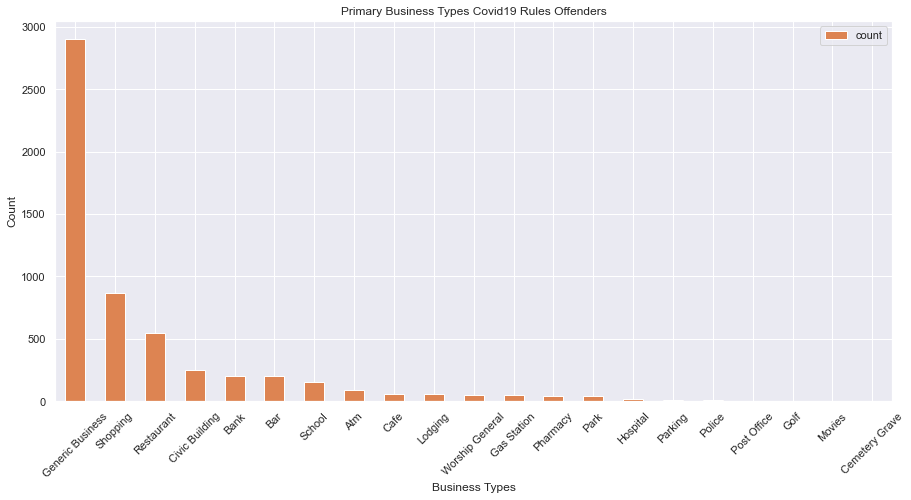

In [57]:
# covid_19_5dec_places["primary_type"].value_counts().to_frame()
biz_offenders = covid_19_5dec_places["primary_type"].value_counts().to_frame().reset_index()
biz_offenders.columns = ["primary_type", "count"]
biz_offenders.plot(x="primary_type", y="count", kind='bar', figsize=(15,7), rot=45, color="C1")
plt.title("Primary Business Types Covid19 Rules Offenders")
plt.xlabel("Business Types")
plt.ylabel("Count");

In [58]:
covid_19_5dec_places["primary_type"].value_counts().to_frame().reset_index()

,index,primary_type
0,Generic Business,2903
1,Shopping,869
2,Restaurant,546
3,Civic Building,253
4,Bank,202
5,Bar,202
6,School,154
7,Atm,88
8,Cafe,60
9,Lodging,59


<img src="../images/business-overview-2.png" width=60%/>

### Which Top 10 Business Types are the Primary Offenders?

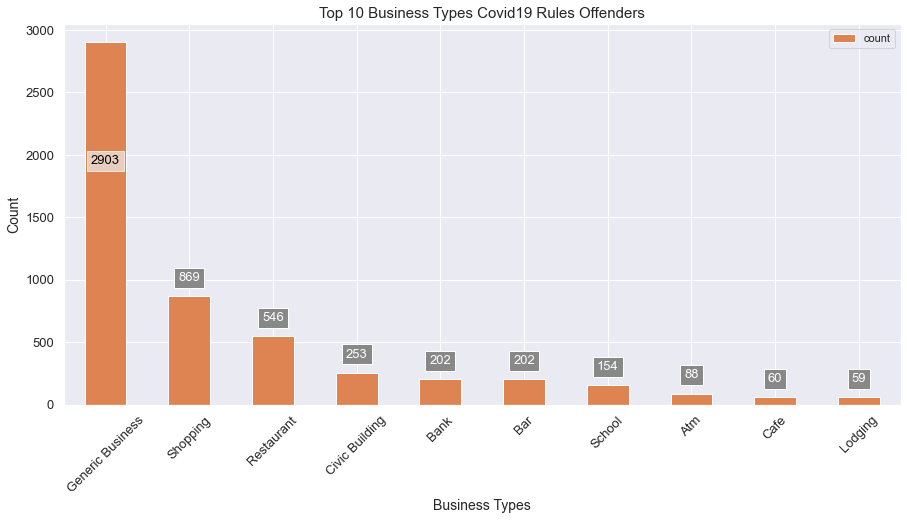

In [59]:
ax = biz_offenders.nlargest(10, "count").plot(x="primary_type", y="count", kind='bar', figsize=(15,7), rot=45, color="C1")

# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels = [x for x in biz_offenders["count"]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 2500):
        ax.text(rect.get_x() + rect.get_width() / 2, height-1000, label, ha='center', va='bottom', color="black", fontsize=13).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+100, label, ha='center', va='bottom', color="white", fontsize=13).set_bbox(dict(facecolor='#888'))

plt.title("Top 10 Business Types Covid19 Rules Offenders", fontsize=15)
ax.set_xlabel("Business Types", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13);

### Which businesses are the most reported offenders (Table)?

Here are the top 20 most reported. **This should be taken with a grain of salt**

In [60]:
covid19_biz_offenses = covid_19_5dec_places.groupby(["name", "address", "city"])[["req_num"]].count().reset_index().sort_values(by="req_num", ascending=False)
covid19_biz_offenses.columns = ["name", "address", "city", "offenses_count"]
covid19_biz_offenses.nlargest(20, "offenses_count")

,name,address,city,offenses_count
622,Express Athletic Uniforms,Broadway,NASHVILLE,124
1333,PNC Bank,Broadway,NASHVILLE,124
1407,Professional photographers of nashville and middle TN,Broadway,NASHVILLE,124
464,Davidson County 3rd Circuit Court,1 Public Sq,NASHVILLE,43
324,Chancery Court,1 Public Sq,NASHVILLE,43
469,Davidson Metropolitan Clerk,1 Public Sq,NASHVILLE,43
462,Davidson 4th Circuit Court Judge,1 Public Sq,NASHVILLE,43
1140,Metropolitan Nashville Clerk's Office,1 Public Sq,NASHVILLE,43
1260,"Nashville Ultimate Party Bus, LLC",717 3rd Ave N,NASHVILLE,40
922,Jonathan's Grille,717 3rd Ave N,NASHVILLE,40


### Which businesses are the most reported offenders (Graph)?

Here are the top 20 most reported. **This should be taken with a grain of salt**

In [61]:
# covid19_biz_offenses = covid_19_5dec_places.groupby(["name", "address", "city"])[["req_num"]].count().reset_index().sort_values(by="req_num", ascending=False)
# covid19_biz_offenses.columns = ["name", "address", "city", "offenses_count"]
# print(covid19_biz_offenses.shape)
# covid19_biz_offenses.head()

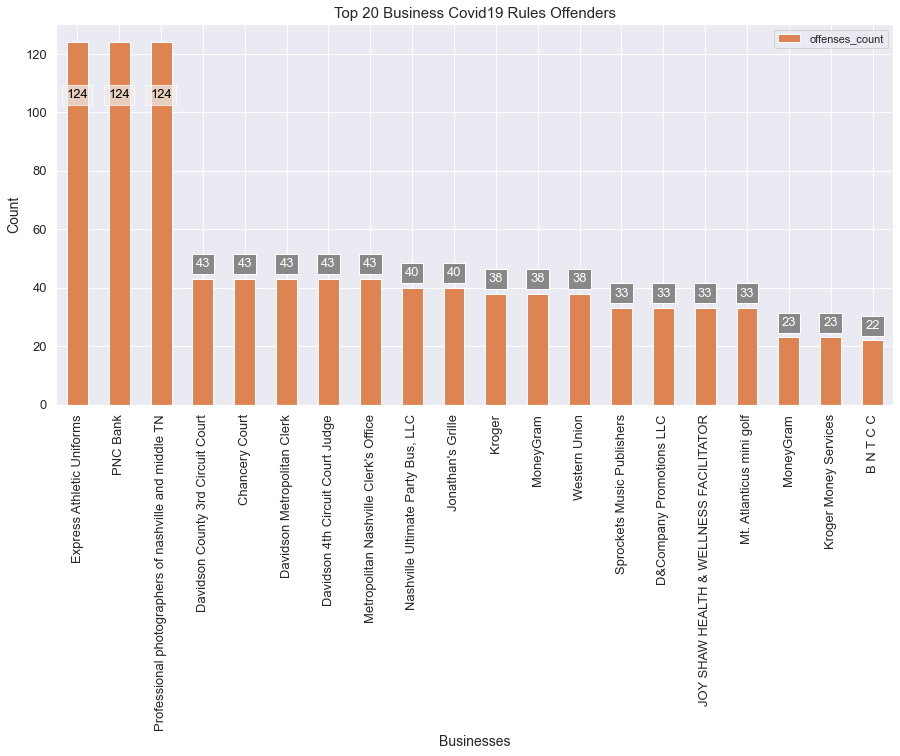

In [62]:
ax = covid19_biz_offenses.nlargest(20, "offenses_count").plot(x="name", y="offenses_count", kind='bar', figsize=(15,7), color="C1")

# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels = [x for x in covid19_biz_offenses["offenses_count"]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 60):
        ax.text(rect.get_x() + rect.get_width() / 2, height-20, label, ha='center', va='bottom', color="black", fontsize=13).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+3, label, ha='center', va='bottom', color="white", fontsize=13).set_bbox(dict(facecolor='#888'))

plt.title("Top 20 Business Covid19 Rules Offenders", fontsize=15)
ax.set_xlabel("Businesses", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13);

---

## Analysis Based on Exact Match of Coordinates

So our dataset then would be the following:

In [63]:
covid_19_exact_places.head()

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday,orig_lat_prec,orig_long_prec,name,vicinity,business_status,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,lat_prec,long_prec,primary_type,mapped_loc_lat,mapped_loc_long
0,470583,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-25 07:11:18,2020-09-25 14:13:46,hubNashville Community,False,False,1500 Church St,NASHVILLE,19.0000000000,37203,36.1574825000,-86.7930523000,"(36.1574825, -86.7930523)",9,25,9/25,Sep,Fri,7,7,Sharp Stephan C MD,"1500 Church Street, Nashville",OPERATIONAL,"1500 Church St, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5644+XQ Nashville, TN, USA",868M5644+XQ,nan,nan,"[doctor, health, point_of_interest, establishment]",ChIJUy9oc-1mZIgRlG9FC734pjI,7,7,Generic Business,36.1574825000,-86.7930523000
1,470583,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-25 07:11:18,2020-09-25 14:13:46,hubNashville Community,False,False,1500 Church St,NASHVILLE,19.0000000000,37203,36.1574825000,-86.7930523000,"(36.1574825, -86.7930523)",9,25,9/25,Sep,Fri,7,7,Clinical Research Associates Inc,"1500 Church Street # 100, Nashville",OPERATIONAL,"1500 Church St, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/generic_business-71.png,"5644+XQ Nashville, TN, USA",868M5644+XQ,3.5000000000,4.0000000000,"[doctor, health, point_of_interest, establishment]",ChIJUy9oc-1mZIgR7xKuFnBR_no,7,7,Generic Business,36.1574825000,-86.7930523000
2,428746,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-28 02:19:03,2020-07-28 18:37:38,hubNashville Community,False,False,3410 Gallatin Pike,NASHVILLE,7.0000000000,37216,36.2101188000,-86.7324397000,"(36.2101188, -86.7324397)",7,28,7/28,Jul,Tue,7,7,Kroger,"3410 Gallatin Pike, Nashville",OPERATIONAL,"3410 Gallatin Pike, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6769+22 Nashville, TN, USA",868M6769+22,3.9000000000,890.0000000000,"[grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJZyYDJgVoZIgRp_UaluUQWjY,7,7,Shopping,36.2101188000,-86.7324397000
3,428746,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-28 02:19:03,2020-07-28 18:37:38,hubNashville Community,False,False,3410 Gallatin Pike,NASHVILLE,7.0000000000,37216,36.2101188000,-86.7324397000,"(36.2101188, -86.7324397)",7,28,7/28,Jul,Tue,7,7,Kroger,"3410 Gallatin Pike, Nashville",OPERATIONAL,"3410 Gallatin Pike, Nan",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6769+22 Nashville, TN, USA",868M6769+22,3.9000000000,890.0000000000,"[grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJZyYDJgVoZIgRp_UaluUQWjY,7,7,Shopping,36.2101188000,-86.7324397000
4,370030,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-17 15:02:52,2020-05-18 16:27:08,hubNashville Community,False,False,3410 Gallatin Pike,NaN,nan,0,36.2101188000,-86.7324397000,"(36.2101188, -86.7324397)",5,17,5/17,May,Sun,7,7,Kroger,"3410 Gallatin Pike, Nashville",OPERATIONAL,"3410 Gallatin Pike, Nashville",https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/shopping-71.png,"6769+22 Nashville, TN, USA",868M6769+22,3.9000000000,890.0000000000,"[grocery_or_supermarket, food, point_of_interest, store, establishment]",ChIJZyYDJgVoZIgRp_UaluUQWjY,7,7,Shopping,36.2101188000,-86.7324397000


### Which Business Types are the Primary Offenders?

In [64]:
covid_19_exact_places["primary_type"].value_counts().to_frame()

,primary_type
Generic Business,788
Shopping,305
Restaurant,138
Civic Building,129
Bank,57
Bar,51
School,45
Atm,44
Pharmacy,25
Lodging,23


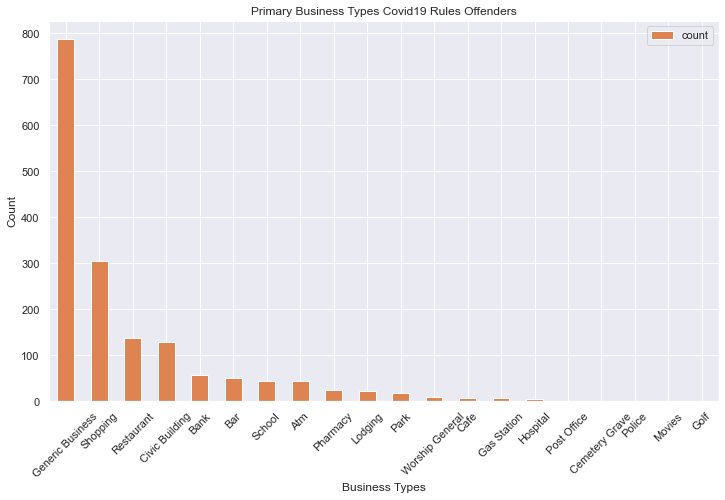

In [65]:
biz_offenders = covid_19_exact_places["primary_type"].value_counts().to_frame().reset_index()
biz_offenders.columns = ["primary_type", "count"]
biz_offenders.plot(x="primary_type", y="count", kind='bar', figsize=(12,7), rot=45, color="C1")
plt.title("Primary Business Types Covid19 Rules Offenders")
plt.xlabel("Business Types")
plt.ylabel("Count");

<img src="../images/business-overview-1.png" width=60%/>

### Which Top 10 Business Types are the Primary Offenders?

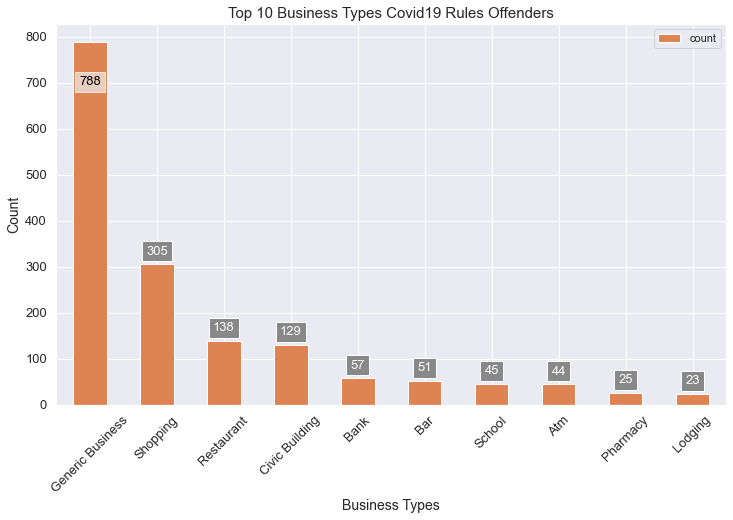

In [66]:
ax = biz_offenders.nlargest(10, "count").plot(x="primary_type", y="count", kind='bar', figsize=(12,7), rot=45, color="C1")

# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels = [x for x in biz_offenders["count"]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 600):
        ax.text(rect.get_x() + rect.get_width() / 2, height-100, label, ha='center', va='bottom', color="black", fontsize=13).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+15, label, ha='center', va='bottom', color="white", fontsize=13).set_bbox(dict(facecolor='#888'))

plt.title("Top 10 Business Types Covid19 Rules Offenders", fontsize=15)
ax.set_xlabel("Business Types", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)

### Which businesses are the most reported offenders?

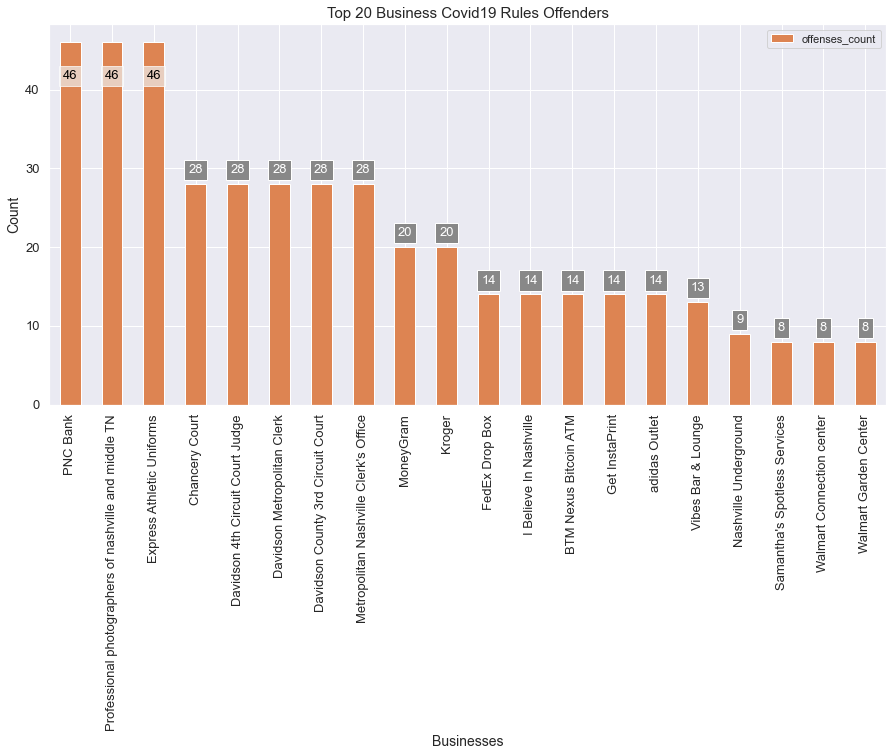

In [67]:
covid19_biz_offenses = covid_19_exact_places.groupby(["name", "address", "city"])[["req_num"]].count().reset_index().sort_values(by="req_num", ascending=False)
covid19_biz_offenses.columns = ["name", "address", "city", "offenses_count"]

ax = covid19_biz_offenses.nlargest(20, "offenses_count").plot(x="name", y="offenses_count", kind='bar', figsize=(15,7), color="C1")

# You can get the list of the bars produced in the plot from the ax.patches member
rects = ax.patches
# Add the labels using the ax.text
labels = [x for x in covid19_biz_offenses["offenses_count"]]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if (height > 40):
        ax.text(rect.get_x() + rect.get_width() / 2, height-5, label, ha='center', va='bottom', color="black", fontsize=13).set_bbox(dict(facecolor='#eee', alpha=0.7))
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height+1, label, ha='center', va='bottom', color="white", fontsize=13).set_bbox(dict(facecolor='#888'))

plt.title("Top 20 Business Covid19 Rules Offenders", fontsize=15)
ax.set_xlabel("Businesses", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13);

Here are the top 20 most reported

In [68]:
covid19_biz_offenses.nlargest(20, "offenses_count")

,name,address,city,offenses_count
413,PNC Bank,Broadway,NASHVILLE,46
440,Professional photographers of nashville and middle TN,Broadway,NASHVILLE,46
191,Express Athletic Uniforms,Broadway,NASHVILLE,46
84,Chancery Court,1 Public Sq,NASHVILLE,28
132,Davidson 4th Circuit Court Judge,1 Public Sq,NASHVILLE,28
137,Davidson Metropolitan Clerk,1 Public Sq,NASHVILLE,28
134,Davidson County 3rd Circuit Court,1 Public Sq,NASHVILLE,28
342,Metropolitan Nashville Clerk's Office,1 Public Sq,NASHVILLE,28
352,MoneyGram,711 Gallatin Ave,NASHVILLE,20
292,Kroger,3410 Gallatin Pike,NASHVILLE,20


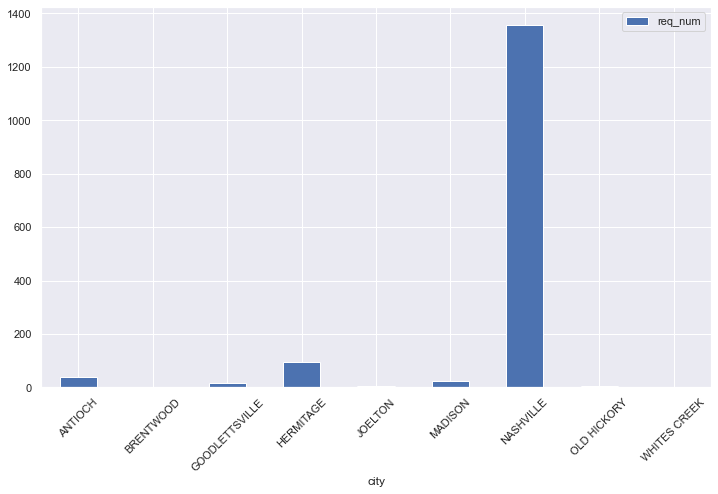

In [69]:
covid_19_exact_places.groupby(["city"])[["req_num"]].count().plot(kind="bar", figsize=(12,7), rot=45);

---

## Edge Cases and Limitations
- Pinpoint accuracy dependent on the actual location of the reporter
  - How far away from the business location is the reporter's location?
- Businesses can be too closed to each other
  - **Reason We did not consider 4-Decimal Coordinates Precision**
- Some Addresses are too broad
  - E.g. *Broadway, Nashville, TN*
- Some businesses are located inside of another business
  - E.g. Gaylord Opryland Hotel contains other small businesses